In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cd /content/drive/MyDrive/dacon/lowresol/

In [ ]:
# !unzip -qn open.zip -d ./open/

In [1]:
!pip install --quiet timm pytorch_lightning==1.7.7 torchmetrics==0.11.1

DEPRECATION: pytorch-lightning 1.7.7 has a non-standard dependency specifier torch>=1.9.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [5]:
import os
import gc
import warnings
import numpy as np
import pandas as pd
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pytorch_lightning as L

from torchinfo import summary
#from glob import glob
import glob
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from torchvision.io import read_image
from torchvision.transforms import v2 as  transforms
from torch.utils.data import Dataset, DataLoader
from transformers import Swinv2Config, Swinv2Model, AutoImageProcessor, AutoModelForImageClassification
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from pytorch_lightning.loggers import WandbLogger  # wandb logger를 임포트


In [2]:
class CFG:
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    NUM_DEVICES = torch.cuda.device_count()
    NUM_WORKERS = os.cpu_count()
    #NUM_CLASSES = 4
    NUM_CLASSES = 8
    EPOCHS = 16
    BATCH_SIZE = (
        32 if torch.cuda.device_count() < 2 
        else (32 * torch.cuda.device_count())
    )
    LR = 0.001
    APPLY_SHUFFLE = True
    SEED = 768
    #HEIGHT = 224
    #WIDTH = 224
    HEIGHT = 256
    WIDTH = 256
    CHANNELS = 3
    #IMAGE_SIZE = (224, 224, 3)
    IMAGE_SIZE = (256, 256, 3)
    
    # Define paths
    #DATASET_PATH = "/content/drive/MyDrive/Colab Notebooks/dataset"
    #TRAIN_PATH = '/content/drive/MyDrive/Colab Notebooks/dataset/train/'
    #TEST_PATH = '/content/drive/MyDrive/Colab Notebooks/dataset/test'
    
    ## Define paths
    #DATASET_PATH = "C:\\Users\\Seo\\Desktop\\Gits\\2024_06_Dron_Competition\\Data"
    #TRAIN_PATH = 'C:\\Users\\Seo\\Desktop\\Gits\\2024_06_Dron_Competition\\Data\\train\\'
    #TEST_PATH = 'C:\\Users\\Seo\\Desktop\\Gits\\2024_06_Dron_Competition\\Data\\test\\'

    # Define paths
    DATASET_PATH = "C:\\Users\\Seo\\Desktop\\2024_06_Dron_Competition\\Datas_3000_3000"
    TRAIN_PATH = 'C:\\Users\\Seo\\Desktop\\2024_06_Dron_Competition\\Datas_3000_3000\\'
    TEST_PATH = 'C:\\Users\\Seo\\Desktop\\2024_06_Dron_Competition\\Datas_3000_3000_downsampling\\'
    
    
# Mute warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

In [3]:
save_dir = 'saved'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

result_dir = 'result'
if not os.path.exists(result_dir):
    os.makedirs(result_dir)

<a id='1.1'></a>
### Get image paths with glob

In [6]:
#%%time
#print(f"{CFG.TRAIN_PATH}**/*.jpg")
train_images = glob.glob(f"{CFG.TRAIN_PATH}**/*.jpg")
valid_images = glob.glob(f"{CFG.TEST_PATH}**/*.jpg")

<a id='1.2'></a>
### Create Pandas DataFrames for paths and labels

In [7]:
def generate_labels(image_paths):
    return [(_.split('\\')[-2:][0]).replace('-', '_') for _ in image_paths]


def build_df(image_paths, labels):
    # Create dataframe
    df = pd.DataFrame({
        'image_path': image_paths,
        'label': generate_labels(labels)
    })
    
    # Return df
    return df

In [8]:
# Build the DataFrames
train_df = build_df(train_images, train_images)
test_df = build_df(valid_images, valid_images)

# View first 5 samples in the dataset
train_df.head(5)

,image_path,label
0,C:\Users\Seo\Desktop\Gits\2024_06_Dron_Competi...,aeroplane
1,C:\Users\Seo\Desktop\Gits\2024_06_Dron_Competi...,aeroplane
2,C:\Users\Seo\Desktop\Gits\2024_06_Dron_Competi...,aeroplane
3,C:\Users\Seo\Desktop\Gits\2024_06_Dron_Competi...,aeroplane
4,C:\Users\Seo\Desktop\Gits\2024_06_Dron_Competi...,aeroplane


In [ ]:
train_no_kfold_df = build_df(train_images, train_images)
valid_no_kfold_df = build_df(valid_images, valid_images)

# View first 5 samples in the dataset
train_no_kfold_df.head(5)

In [ ]:
valid_no_kfold_df.head(5)

In [ ]:
train_no_kfold_df.shape, valid_no_kfold_df.shape

<a id='1.3'></a>
### Load & View Random Sample Image

In [13]:
from PIL import Image
import matplotlib.pyplot as plt

In [14]:
def _load(image_path, as_tensor=True):
    # Read and decode an image file to a uint8 tensor
    image = Image.open(image_path)
    
    if as_tensor:
        converter = transforms.Compose([
            transforms.ToTensor(), 
            #transforms.Grayscale()
        ])
        return converter(image)
    else:
        return image


def view_sample(image, label, color_map='rgb', fig_size=(8, 10)):
    plt.figure(figsize=fig_size)
    
    if color_map=='rgb':
        plt.imshow(image)
    else:
        plt.imshow(image, cmap=color_map)
    
    plt.title(f'Label: {label}', fontsize=16)
    return

In [15]:
import random

c:\Users\Seo\anaconda3\envs\Dron_PytorchLightning\lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


ValueError: 'mako' is not a valid value for cmap; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Grays', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_grey', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gist_yerg', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'grey', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

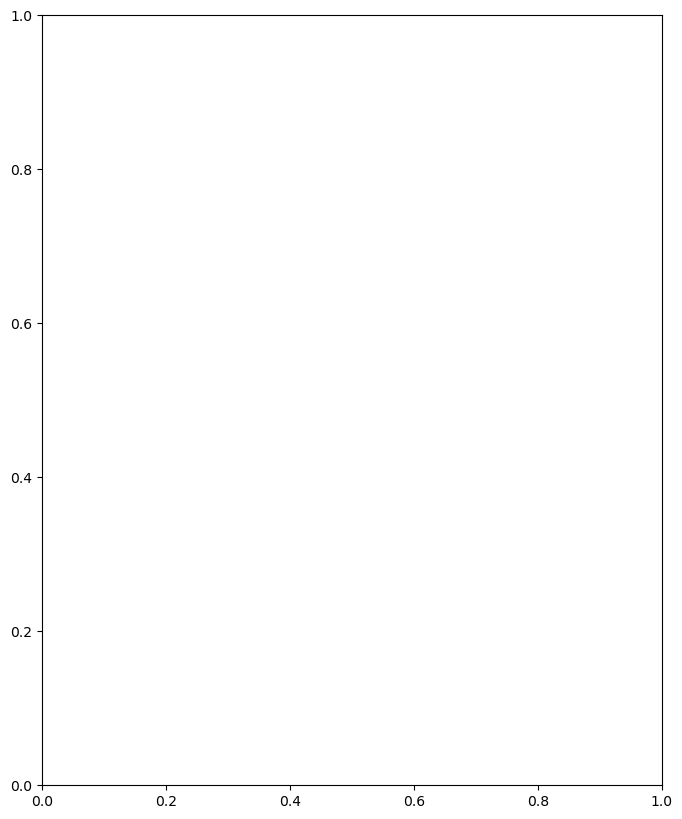

In [16]:
# Select random sample from train_df
idx = random.sample(train_df.index.to_list(), 1)[0]

# Load the random sample and label
sample_image, sample_label = _load(train_df.image_path[idx]), train_df.label[idx]

# View the random sample
view_sample(
    sample_image.permute(1, 2, 0),
    sample_label,
    color_map='mako',
)

<a id='1.5'></a>
### Create Train and Validation sets

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
# Create Train/Val split with Training Set
train_split_idx, val_split_idx, _, _ = (
    train_test_split(
        train_df.index, 
        train_df.label, 
        test_size=0.20,
        stratify=train_df.label,
        random_state=CFG.SEED
    )
)

In [19]:
# Get training and remaining data
train_new_df = train_df.iloc[train_split_idx].reset_index(drop=True)
val_df = train_df.iloc[val_split_idx].reset_index(drop=True)

# View shapes
train_new_df.shape, val_df.shape

((2440, 2), (611, 2))

In [20]:
class CustomDataset(Dataset):
    def __init__(self, df, path_col,  mode='train'):
        self.df = df
        self.path_col = path_col
        self.mode = mode

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if self.mode == 'train':
            row = self.df.iloc[idx]
            image = read_image(row[self.path_col])/256.
            label = row['class']
            data = {
                'image':image,
                'label':label
            }
            return data
        elif self.mode == 'val':
            row = self.df.iloc[idx]
            image = read_image(row[self.path_col])/256.
            label = row['class']
            data = {
                'image':image,
                'label':label
            }
            return data
        elif self.mode == 'inference':
            row = self.df.iloc[idx]
            image = read_image(row[self.path_col])/256.
            data = {
                'image':image,
            }
            return data

    def train_transform(self, image):
        pass

In [21]:
class CustomCollateFn:
    def __init__(self, transform, mode):
        self.mode = mode
        self.transform = transform

    def __call__(self, batch):
        if self.mode=='train':
            pixel_values = torch.stack([self.transform(data['image']) for data in batch])
            label = torch.LongTensor([data['label'] for data in batch])
            return {
                'pixel_values':pixel_values,
                'label':label,
            }
        elif self.mode=='val':
            pixel_values = torch.stack([self.transform(data['image']) for data in batch])
            label = torch.LongTensor([data['label'] for data in batch])
            return {
                'pixel_values':pixel_values,
                'label':label,
            }
        elif self.mode=='inference':
            pixel_values = torch.stack([self.transform(data['image']) for data in batch])
            return {
                'pixel_values':pixel_values,
            }

In [41]:
class CustomModel(nn.Module):
    def __init__(self, model):
        super(CustomModel, self).__init__()
        self.model = model
        self.clf = nn.Sequential(
            nn.Tanh(),
            nn.LazyLinear(CFG.NUM_CLASSES),
        )

#     @torch.compile
    def forward(self, x, label=None):
        # original
        # x = self.model(x).pooler_output
        x = self.model(x)
        # pooler_output 대신에 last_hidden_state 사용
        #x = outputs.last_hidden_state[:, 0]  # [CLS] 토큰에 해당하는 벡터 추출
        #x = self.clf(x)
        loss = None
        if label is not None:
            loss = nn.CrossEntropyLoss()(x, label)
        probs = nn.LogSoftmax(dim=-1)(x)
        return probs, loss

class LitCustomModel(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = CustomModel(model)
        self.validation_step_output = []

    def configure_optimizers(self):
        opt = torch.optim.AdamW(self.parameters(), lr=1e-5)
        return opt

    def training_step(self, batch, batch_idx=None):
        x = batch['pixel_values']
        label = batch['label']
        probs, loss = self.model(x, label)
        self.log(f"train_loss", loss, on_step=True, on_epoch=False)
        return loss

    def validation_step(self, batch, batch_idx=None):
        x = batch['pixel_values']
        label = batch['label']
        probs, loss = self.model(x, label)
        self.validation_step_output.append([probs,label])
        return loss

    def predict_step(self, batch, batch_idx=None):
        x = batch['pixel_values']
        probs, _ = self.model(x)
        return probs

    def validation_epoch_end(self, step_output):
        pred = torch.cat([x for x, _ in self.validation_step_output]).cpu().detach().numpy().argmax(1)
        label = torch.cat([label for _, label in self.validation_step_output]).cpu().detach().numpy()
        score = f1_score(label,pred, average='macro')
        self.log("val_score", score)
        self.validation_step_output.clear()
        return score

In [24]:
SEED = 42
N_SPLIT = 5
BATCH_SIZE = 12

In [25]:
L.seed_everything(SEED)

Global seed set to 42


42

In [26]:
#train_df = pd.read_csv('./open/train.csv')
train_df = train_new_df
#train_df['img_path'] = train_df['img_path'].apply(lambda x: os.path.join('./open', x))
#train_df['upscale_img_path'] = train_df['upscale_img_path'].apply(lambda x: os.path.join('./open', x))
le = LabelEncoder()
train_df['class'] = le.fit_transform(train_df['label'])

In [ ]:
le_no_kfold = LabelEncoder()
train_no_kfold_df['class'] = le_no_kfold.fit_transform(train_no_kfold_df['label'])
valid_no_kfold_df['class'] = le_no_kfold.fit_transform(valid_no_kfold_df['label'])

In [ ]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

# 예시 데이터프레임 생성
# valid_no_kfold_df = pd.DataFrame({
#     'label': [...],
#     'class': [...]
# })

# 샘플링할 데이터 비율 (예: 전체 데이터의 20%)
sample_ratio = 0.4

# StratifiedShuffleSplit 객체 생성
splitter = StratifiedShuffleSplit(n_splits=1, test_size=sample_ratio, random_state=42)

# 샘플링
for train_index, sample_index in splitter.split(valid_no_kfold_df, valid_no_kfold_df['class']):
    sampled_df = valid_no_kfold_df.iloc[sample_index]

valid_no_kfold_df = sampled_df

In [9]:
#if not len(train_df) == len(os.listdir('./open/train')):
#    raise ValueError()

In [27]:
skf = StratifiedKFold(n_splits=N_SPLIT, random_state=SEED, shuffle=True)

In [28]:
train_transform = transforms.Compose([
    transforms.Resize(size=(256,256), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
])
val_transform = transforms.Compose([
    transforms.Resize(size=(256,256), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
])

train_collate_fn = CustomCollateFn(train_transform, 'train')
val_collate_fn = CustomCollateFn(val_transform, 'val')

In [29]:
class EfficientNetV2Model(nn.Module):
    def __init__(self, backbone_model, name='efficientnet-v2-large', 
                 num_classes=CFG.NUM_CLASSES, device=CFG.DEVICE):
        super(EfficientNetV2Model, self).__init__()
        
        self.backbone_model = backbone_model
        self.device = device
        self.num_classes = num_classes
        self.name = name
        
        classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.2, inplace=True), 
            nn.Linear(in_features=1280, out_features=256, bias=True),
            nn.GELU(),
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(in_features=256, out_features=num_classes, bias=False)
        ).to(device)
        
        self._set_classifier(classifier)
        
    def _set_classifier(self, classifier:nn.Module) -> None:
        self.backbone_model.classifier = classifier
    
    def forward(self, image):
        return self.backbone_model(image)

In [30]:
def get_effiecientnetv2_model(
    device: torch.device=CFG.NUM_CLASSES) -> nn.Module:
    # Set the manual seeds
    torch.manual_seed(CFG.SEED)
    torch.cuda.manual_seed(CFG.SEED)

    # Get model weights
    model_weights = (
        torchvision
        .models
        .EfficientNet_V2_L_Weights
        .DEFAULT
    )
    
    # Get model and push to device
    model = (
        torchvision.models.efficientnet_v2_l(
            weights=model_weights
        )
    ).to(device) 
    
    # Freeze Model Parameters
    for param in model.features.parameters():
        param.requires_grad = False
        
    return model

In [31]:
# Get EfficientNet v2 model
backbone_model = get_effiecientnetv2_model(CFG.DEVICE)

In [32]:
efficientnetv2_params = {
    'backbone_model'    : backbone_model,
    'name'              : 'efficientnet-v2-large',
    'device'            : CFG.DEVICE
}

# Generate Model
efficientnet_model = EfficientNetV2Model(**efficientnetv2_params)

# If using GPU T4 x2 setup, use this:
if CFG.NUM_DEVICES > 1:
    efficientnet_model = nn.DataParallel(efficientnet_model)

In [33]:
# View model summary
summary(
    model=efficientnet_model, 
    input_size=(CFG.BATCH_SIZE, CFG.CHANNELS, CFG.WIDTH, CFG.HEIGHT),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
EfficientNetV2Model (EfficientNetV2Model)                         [32, 3, 256, 256]    [32, 8]              --                   Partial
├─EfficientNet (backbone_model)                                   [32, 3, 256, 256]    [32, 8]              --                   Partial
│    └─Sequential (features)                                      [32, 3, 256, 256]    [32, 1280, 8, 8]     --                   False
│    │    └─Conv2dNormActivation (0)                              [32, 3, 256, 256]    [32, 32, 128, 128]   (928)                False
│    │    └─Sequential (1)                                        [32, 32, 128, 128]   [32, 32, 128, 128]   (37,120)             False
│    │    └─Sequential (2)                                        [32, 32, 128, 128]   [32, 64, 64, 64]     (1,032,320)          False
│    │    └─Sequential (3)                     

In [42]:
# View model summary
summary(
    model=Swinv2Model.from_pretrained("microsoft/swinv2-large-patch4-window12to16-192to256-22kto1k-ft"), 
    input_size=(CFG.BATCH_SIZE, CFG.CHANNELS, CFG.WIDTH, CFG.HEIGHT),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                                               Input Shape          Output Shape         Param #              Trainable
Swinv2Model (Swinv2Model)                                                             [32, 3, 256, 256]    [32, 1536]           --                   True
├─Swinv2Embeddings (embeddings)                                                       [32, 3, 256, 256]    [32, 4096, 192]      --                   True
│    └─Swinv2PatchEmbeddings (patch_embeddings)                                       [32, 3, 256, 256]    [32, 4096, 192]      --                   True
│    │    └─Conv2d (projection)                                                       [32, 3, 256, 256]    [32, 192, 64, 64]    9,408                True
│    └─LayerNorm (norm)                                                               [32, 4096, 192]      [32, 4096, 192]      384                  True
│    └─Dropout (dropout)                                               

In [40]:
for fold_idx, (train_index, val_index) in enumerate(skf.split(train_df, train_df['class'])):
    train_fold_df = train_df.loc[train_index,:]
    val_fold_df = train_df.loc[val_index,:]

    train_dataset = CustomDataset(train_fold_df, 'image_path', mode='train')
    val_dataset = CustomDataset(val_fold_df, 'image_path', mode='val')

    train_dataloader = DataLoader(train_dataset, collate_fn=train_collate_fn, batch_size=BATCH_SIZE)
    val_dataloader = DataLoader(val_dataset, collate_fn=val_collate_fn, batch_size=BATCH_SIZE*2)

    #model = Swinv2Model.from_pretrained("microsoft/swinv2-large-patch4-window12to16-192to256-22kto1k-ft")
    model = efficientnet_model
    lit_model = LitCustomModel(model)

    checkpoint_callback = ModelCheckpoint(
        monitor='val_score',
        mode='max',
        dirpath='./checkpoints/',
        filename=f'swinv2-large-resize-fold_idx={fold_idx}'+'-{epoch:02d}-{train_loss:.4f}-{val_score:.4f}',
        #filename=f'EfficientNetV2Model={fold_idx}'+'-{epoch:02d}-{train_loss:.4f}-{val_score:.4f}',
        save_top_k=1,
        save_weights_only=True,
        verbose=True
    )

    # wandb logger 초기화
    wandb_logger = WandbLogger(name=f"swinv2_Fold{fold_idx}", project="Bird_Competition", log_model="all")
    #wandb_logger = WandbLogger(name=f"EfficientNetV2Model_Fold{fold_idx}", project="Bird_Competition", log_model="all")

    earlystopping_callback = EarlyStopping(monitor="val_score", mode="max", patience=3)
    trainer = L.Trainer(max_epochs=100, accelerator='auto', precision=32, callbacks=[checkpoint_callback, earlystopping_callback], val_check_interval=0.5, logger=wandb_logger)
    trainer.fit(lit_model, train_dataloader, val_dataloader)

    model.cpu()
    lit_model.cpu()
    del model, lit_model, checkpoint_callback, earlystopping_callback, trainer
    #wandb_logger.experiment.finish()
    gc.collect()
    torch.cuda.empty_cache()

c:\Users\Seo\anaconda3\envs\Dron_PytorchLightning\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
c:\Users\Seo\anaconda3\envs\Dron_PytorchLightning\lib\site-packages\pytorch_lightning\loggers\wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\Seo\anaconda3\envs\Dron_PytorchLightning\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:616: UserWarning: Checkpoint directory ./checkpoints/ exists and is not empty.
  rank_zero_warn(f"C

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\Seo\anaconda3\envs\Dron_PytorchLightning\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


TypeError: tanh(): argument 'input' (position 1) must be Tensor, not Swinv2ModelOutput

In [ ]:
test_df = pd.read_csv('./open/test.csv')
test_df['img_path'] = test_df['img_path'].apply(lambda x: os.path.join('./open', x))

In [ ]:
if not len(test_df) == len(os.listdir('./open/test')):
    raise ValueError()

In [ ]:
test_transform = transforms.Compose([
    transforms.Resize(size=(256,256), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
])

test_collate_fn = CustomCollateFn(test_transform, 'inference')
test_dataset = CustomDataset(test_df, 'img_path', mode='inference')
test_dataloader = DataLoader(test_dataset, collate_fn=test_collate_fn, batch_size=BATCH_SIZE*2)

In [ ]:
fold_preds = []
for checkpoint_path in glob('./checkpoints/swinv2-large-resize*.ckpt'):
    model = Swinv2Model.from_pretrained("microsoft/swinv2-large-patch4-window12to16-192to256-22kto1k-ft")
    lit_model = LitCustomModel.load_from_checkpoint(checkpoint_path, model=model)
    trainer = L.Trainer( accelerator='auto', precision=32)
    preds = trainer.predict(lit_model, test_dataloader)
    preds = torch.cat(preds,dim=0).detach().cpu().numpy().argmax(1)
    fold_preds.append(preds)
pred_ensemble = list(map(lambda x: np.bincount(x).argmax(),np.stack(fold_preds,axis=1)))

In [ ]:
submission = pd.read_csv('./open/sample_submission.csv')

In [ ]:
submission['label'] = le.inverse_transform(pred_ensemble)

In [ ]:
submission.to_csv('./submissions/swinv2_large_resize.csv',index=False)